# 悉尼天气预测

通过对悉尼当天的各种气象因素（湿度，压力，风向等）对第二天是否下雨，降水量多少进行预测。

数据集来源：https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## 导入所需库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = None
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest,f_regression,f_classif,chi2
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 数据清理

读取数据集，检查数据类型以及缺失值数量。这里只读取悉尼天气数据，因此筛选掉其他城市的气象数据。

In [2]:
weather=pd.read_csv('weatheraus.csv')
weather_sydney=weather[weather['Location']=='Sydney']

In [3]:
weather_sydney.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
29497,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,6.0,Yes
29498,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,6.6,Yes
29499,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,18.8,Yes
29500,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,77.4,Yes
29501,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,1.6,Yes


In [4]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3331 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3331 non-null object
RISK_MM          3337 non-null float

In [5]:
weather_sydney.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,3334.000000,3335.000000,3331.000000,3286.000000,3321.000000,2301.000000,3311.000000,3312.000000,3323.000000,3324.000000,3317.000000,3318.000000,2771.000000,2776.000000,3333.000000,3333.000000,3337.000000
mean,14.865057,23.002339,3.330231,5.187432,7.179374,41.761408,15.070674,19.335447,68.229010,54.699158,1018.346156,1016.018774,4.181523,4.218660,17.819742,21.533333,3.319868
std,4.553641,4.494638,9.895172,2.777407,3.810886,13.007523,7.079724,7.482554,15.085355,16.293530,7.021571,7.032211,2.749578,2.641885,4.897177,4.303737,9.885066
min,4.300000,11.700000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,19.000000,10.000000,986.700000,989.800000,0.000000,0.000000,6.400000,10.200000,0.000000
25%,11.000000,19.600000,0.000000,3.200000,4.300000,31.000000,9.000000,15.000000,58.000000,44.000000,1013.700000,1011.300000,1.000000,1.000000,13.800000,18.400000,0.000000
50%,14.900000,22.800000,0.000000,4.800000,8.300000,41.000000,15.000000,19.000000,69.000000,56.000000,1018.600000,1016.300000,5.000000,4.000000,18.200000,21.300000,0.000000
75%,18.700000,26.000000,1.400000,7.000000,10.200000,50.000000,20.000000,24.000000,80.000000,65.000000,1023.100000,1020.800000,7.000000,7.000000,21.700000,24.500000,1.400000
max,27.600000,45.800000,119.400000,18.400000,13.600000,96.000000,54.000000,57.000000,100.000000,99.000000,1039.000000,1036.700000,9.000000,8.000000,36.500000,44.700000,119.400000


从info()中可看出缺失值主要存在于每日最强风的风力与风速，以及云层厚度。接下来检查数据集中是否有重复数据，例如同一天的气象数据出现了多次。

In [6]:
weather_sydney=weather_sydney.drop_duplicates(subset='Date', keep='first', inplace=False)
weather_sydney.shape[0]

3337

数据集依旧是3337行，所以数据集中并没有重复日期。

预测变量‘RainToday’（今日是否下雨），‘Rainfall’（今日降水量）中各有6个缺失值，但是此变量值可由上一天的‘RainTomorrow’（明日是否下雨）及‘RISK_MM’（明日降水量）推测出，所以‘RainToday’与‘Rainfall’的缺失值可以用此法填补。

In [7]:
for index in weather_sydney.index:
    if pd.isnull(weather_sydney.loc[index,'RainToday']):
        weather_sydney.loc[index,['RainToday']]=weather_sydney.loc[index-1,['RainTomorrow']][0]
    if pd.isnull(weather_sydney.loc[index,'Rainfall']):
        weather_sydney.loc[index,['Rainfall']]=weather_sydney.loc[index-1,['RISK_MM']][0]

对于其余的缺失值我们选择将其所在行删除，最后剩余1692行数据。之后剔除不需要的列‘Date’，‘Location’，‘RainToday’，‘RainTomorrow’。

In [8]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3337 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3337 non-null object
RISK_MM          3337 non-null float

In [9]:
weather_sydney=weather_sydney.dropna()
weather_sydney=weather_sydney.drop(columns=['Date','Location'])

对于类别变量，我们将‘Yes’和‘No’统一转化为1和0，并将风向变量向量化，即独热编码。

In [10]:
weather_sydney2=weather_sydney

In [11]:
weather_sydney=weather_sydney.replace('Yes',1)
weather_sydney=weather_sydney.replace('No',0)
weather_sydney= pd.get_dummies(weather_sydney,columns = ['WindGustDir','WindDir9am','WindDir3pm'],drop_first=True)

## 基础分析

首先分析风向因素，这里选取第二天会下雨的数据（RainTomorrow=Yes），统计下雨前一天的风向分布。

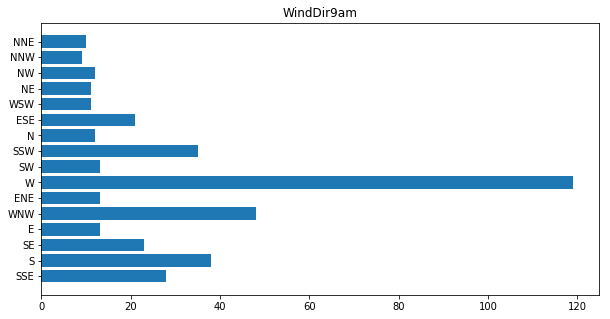

In [12]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir9am'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir9am')
plt.show()

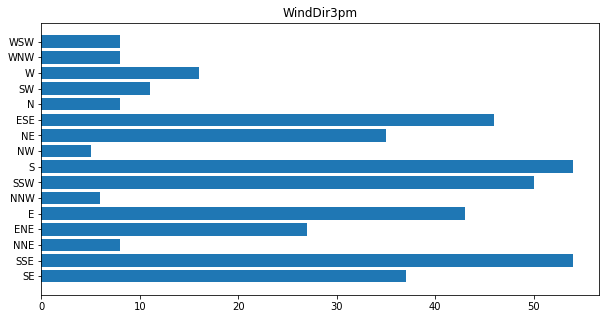

In [13]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir3pm'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir3pm')
plt.show()

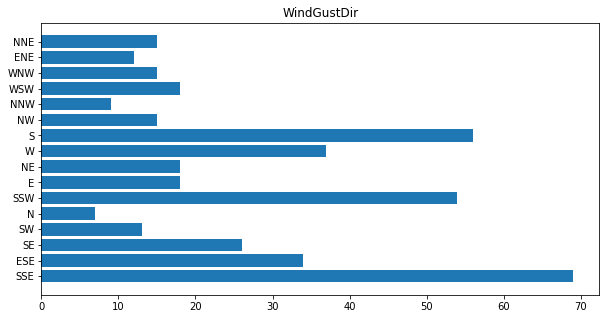

In [14]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindGustDir'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindGustDir')
plt.show()

可看出，如果上午9点风向为西风，下午3点风向大致为南风或东风，当日最大风为偏西南风时，第二天下雨情况居多。悉尼地处澳大利亚东南部，除了上午9点是情况，其他情况皆符合常理。

接下来分析云层厚度与降水的关系。

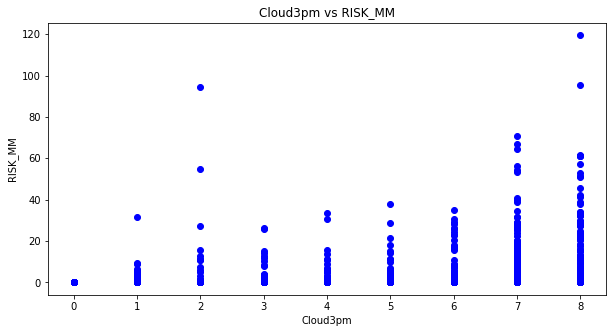

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Cloud3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Cloud3pm vs RISK_MM')
plt.xlabel('Cloud3pm')
plt.ylabel('RISK_MM')
plt.show()

除了个别极端情况，总体上看随着云层厚度增加，第二天降水量有上升趋势。

湿度与降水也可观察到正相关关系。

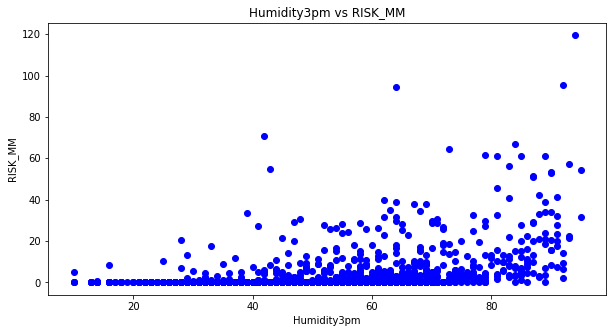

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Humidity3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Humidity3pm vs RISK_MM')
plt.xlabel('Humidity3pm')
plt.ylabel('RISK_MM')
plt.show()

今天的降水量之间是否对明天的降水量有影响？由散点图看是呈负相关。

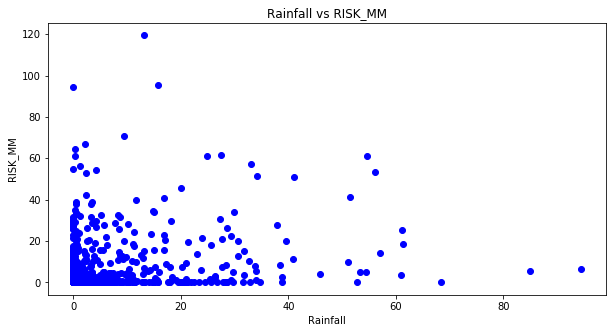

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Rainfall'],weather_sydney2['RISK_MM'],color='b')
plt.title('Rainfall vs RISK_MM')
plt.xlabel('Rainfall')
plt.ylabel('RISK_MM')
plt.show()

## 建模

### 线性回归

挑选其中对因变量影响最大的10个自变量

In [18]:
y=weather_sydney['RISK_MM']
X=weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]
best=SelectKBest(f_regression, k=10)
best.fit(X,y)

SelectKBest(k=10, score_func=<function f_regression at 0x0000025219987598>)

In [19]:
columns=X.columns[best.get_support(indices=True)]
print(columns)

Index(['Cloud3pm', 'Cloud9am', 'Humidity3pm', 'Humidity9am', 'MaxTemp',
       'Rainfall', 'Sunshine', 'Temp3pm', 'WindDir9am_S', 'WindGustSpeed'],
      dtype='object')


In [20]:
X=best.transform(X)

In [21]:
lin = LinearRegression()
lin.fit(X,y)
pd.DataFrame(data={'feature':columns,'coef':lin.coef_})

,feature,coef
0,Cloud3pm,0.043300
1,Cloud9am,-0.155410
2,Humidity3pm,0.159711
3,Humidity9am,-0.000762
4,MaxTemp,-0.270351
5,Rainfall,0.159397
6,Sunshine,-0.450469
7,Temp3pm,0.176390
8,WindDir9am_S,1.955829
9,WindGustSpeed,0.150976


In [22]:
y_pred = lin.predict(X)
r2_score(y, y_pred)

0.25579353440315455

在此我们得到模型的$R^2$约为0.26，鉴于气象有很强的不确定性，在此可认为模型拟合情况较为良好。
首先观察模型系数，‘WindDir9am_S’的系数最高，说明上午9点刮西南风可能会增加第二天的降水量。还可发现在适度与云层厚度中，上午9时的适度与云层厚度对第二天的降水量有负作用。然而我们注意到，在这个模型里，今天的降水量会提升第二天的降水量。

## 逻辑回归

尝试仅预测是否下雨，即分类。这里我们使用逻辑回归。使用前先剔除掉数据集中记录明日降水量的‘RISK_MM’，并将‘RainTomorrow’作为预测对象。

In [23]:
y=weather_sydney['RainTomorrow']
X=weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])]
best=SelectKBest(f_classif, k=10)
best.fit(X,y)


SelectKBest(k=10, score_func=<function f_classif at 0x0000025219987400>)

In [24]:
columns=(X.columns[best.get_support(indices=True)])
X=best.transform(X)

In [32]:
weather_sydney['RainTomorrow'].value_counts()

0    1276
1     416
Name: RainTomorrow, dtype: int64

数据类别有些不平衡，明显下雨天的样本过少。因此我们使用交叉验证法对类别权重进行调参。

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

Best parameters : {'class_weight': {0: 0.23947368421052628, 1: 0.7605263157894737}}


C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


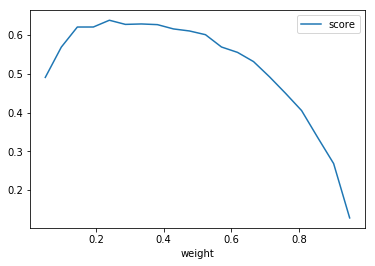

In [72]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [73]:
cv_results=pd.DataFrame(gsc.cv_results_)
cv_results

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\skle

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.008678,0.002321,0.000799,0.000400,"{0: 0.05, 1: 0.95}","{'class_weight': {0: 0.05, 1: 0.95}}",0.503067,0.448276,0.550336,0.500000,...,0.480211,0.491605,0.485010,0.490591,0.493927,0.483168,0.506224,0.490340,0.491892,0.008370
1,0.007399,0.002368,0.000895,0.000538,"{0: 0.09736842105263158, 1: 0.9026315789473685}","{'class_weight': {0: 0.09736842105263158, 1: 0...",0.586466,0.507042,0.666667,0.560606,...,0.563769,0.575480,0.569777,0.581024,0.573322,0.569065,0.578293,0.569777,0.573379,0.005770
2,0.007392,0.000805,0.000597,0.000488,"{0: 0.14473684210526316, 1: 0.8552631578947368}","{'class_weight': {0: 0.14473684210526316, 1: 0...",0.638655,0.555556,0.728972,0.569106,...,0.611418,0.629981,0.615385,0.634378,0.624883,0.617375,0.621974,0.616962,0.621540,0.006820
3,0.006788,0.000752,0.000699,0.000641,"{0: 0.19210526315789472, 1: 0.8078947368421052}","{'class_weight': {0: 0.19210526315789472, 1: 0...",0.660714,0.535714,0.680412,0.564103,...,0.616803,0.640333,0.621259,0.644351,0.627572,0.623853,0.629400,0.626775,0.629169,0.008139
4,0.007196,0.002126,0.000690,0.000630,"{0: 0.23947368421052628, 1: 0.7605263157894737}","{'class_weight': {0: 0.23947368421052628, 1: 0...",0.725490,0.571429,0.711111,0.601942,...,0.629834,0.646328,0.632402,0.650000,0.645304,0.639821,0.640884,0.638581,0.639800,0.007554
5,0.007091,0.000823,0.000891,0.000297,"{0: 0.28684210526315784, 1: 0.7131578947368422}","{'class_weight': {0: 0.28684210526315784, 1: 0...",0.731183,0.556701,0.727273,0.595745,...,0.638655,0.652913,0.642857,0.646562,0.657143,0.649758,0.645084,0.637337,0.646231,0.007329
6,0.007284,0.000997,0.000803,0.000600,"{0: 0.33421052631578946, 1: 0.6657894736842105}","{'class_weight': {0: 0.33421052631578946, 1: 0...",0.712644,0.537634,0.698795,0.619048,...,0.631714,0.643939,0.643939,0.641944,0.650572,0.639490,0.636943,0.632911,0.640908,0.009028
7,0.007291,0.000894,0.000801,0.000401,"{0: 0.381578947368421, 1: 0.618421052631579}","{'class_weight': {0: 0.381578947368421, 1: 0.6...",0.705882,0.511111,0.675000,0.607595,...,0.630286,0.634409,0.636242,0.639676,0.635262,0.639676,0.644295,0.625503,0.635419,0.008439
8,0.007189,0.000394,0.000501,0.000501,"{0: 0.4289473684210526, 1: 0.5710526315789475}","{'class_weight': {0: 0.4289473684210526, 1: 0....",0.675000,0.517647,0.666667,0.594595,...,0.629471,0.635854,0.629213,0.640114,0.635983,0.635461,0.637394,0.617772,0.633816,0.007215
9,0.008287,0.001344,0.000796,0.000398,"{0: 0.47631578947368414, 1: 0.5236842105263159}","{'class_weight': {0: 0.47631578947368414, 1: 0...",0.666667,0.531646,0.630137,0.529412,...,0.618619,0.628319,0.621100,0.622951,0.628319,0.628743,0.635821,0.616071,0.625879,0.007470


In [76]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
logmean=gsc.cv_results_['mean_test_score'][index]
logstd=gsc.cv_results_['std_test_score'][index]
log_score=cv_results.loc[4,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [77]:
index

(array([4], dtype=int64),)

In [51]:
print('mean_score:',logmean)
print('std_score:',logstd)

mean_score: [0.6381109]
std_score: [0.0549206]


In [74]:
gsc.best_estimator_

LogisticRegression(C=1.0,
          class_weight={0: 0.23947368421052628, 1: 0.7605263157894737},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

In [41]:
gsc.best_score_

0.6381109009390837

在权重为0.24时模型得分最高。f1值约为0.63。

## 决策森林

In [52]:
from sklearn.ensemble import RandomForestClassifier

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest

Best parameters : {'max_depth': 6}


C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


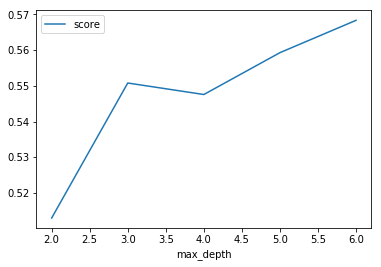

In [65]:
gsc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'max_depth': [2,3,4,5,6]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'max_depth': [2,3,4,5,6] })
dataz.plot(x='max_depth')

可见当‘max_depth’=5时模型f1值最高。

In [68]:
cv_results=pd.DataFrame(gsc.cv_results_)
cv_results

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Program Files\Anaconda3\lib\site-packages\skle

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.011063,0.002842,0.001296,0.000456,2,{'max_depth': 2},0.584615,0.557377,0.542373,0.456140,...,0.533088,0.554745,0.505747,0.562044,0.504780,0.541516,0.562044,0.517241,0.535826,0.020010
1,0.010473,0.001852,0.001697,0.001788,3,{'max_depth': 3},0.666667,0.550725,0.593750,0.516129,...,0.555160,0.581560,0.584229,0.602113,0.563830,0.603448,0.565217,0.519924,0.576647,0.025341
2,0.011471,0.001683,0.001498,0.000672,4,{'max_depth': 4},0.597015,0.545455,0.615385,0.468750,...,0.617747,0.596859,0.615917,0.620102,0.614853,0.584071,0.640678,0.583333,0.607659,0.018260
3,0.013665,0.003216,0.001297,0.000457,5,{'max_depth': 5},0.693333,0.537313,0.571429,0.426230,...,0.610229,0.650927,0.656514,0.638743,0.633391,0.661074,0.644714,0.609457,0.642495,0.019532
4,0.014764,0.001716,0.001694,0.000897,6,{'max_depth': 6},0.685714,0.550725,0.575758,0.428571,...,0.694215,0.680412,0.691030,0.708738,0.674576,0.691275,0.707038,0.696517,0.698423,0.015151


In [69]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'split5_train_score', 'split6_train_score',
       'split7_train_score', 'split8_train_score', 'split9_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [70]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
frmean=gsc.cv_results_['mean_test_score'][index]
frstd=gsc.cv_results_['std_test_score'][index]
fr_score=cv_results.loc[3,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [58]:
print('mean_score:',frmean)
print('std_score:',frstd)

mean_score: [0.58049864]
std_score: [0.03545727]


## 假设检验

从结果上看似乎逻辑回归模型f1值更高，记逻辑回归的f1值为$F1_log$,随机森林模型的f1值为$F1_fr$。现在我们提出如下假设：
$H_0:F1_{log}=F1_{fr}$
$H_1:F1_{log}>F1_{fr}$

In [79]:
from scipy import stats


In [82]:
stats.mstats.ttest_ind(log_score,fr_score).pvalue<0.5

True

拒绝原假设，可认为逻辑回归的f1值高于随机森林模型。